#### Look at some statistics (like single visit depth, seeing, etc) between v1.3 baseline vs. v1.4.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import os
import pandas as pd
import healpy as hp
from copy import deepcopy

In [2]:
import lsst.sims.maf.maps as maps
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.stackers as mafStackers

In [10]:
%matplotlib inline

In [4]:
fontsize = 18
rcparams = {}
rcparams['figure.figsize'] = (10, 6)
rcparams['axes.labelsize'] = fontsize
rcparams['legend.fontsize'] = fontsize-4
rcparams['axes.titlesize'] = fontsize
rcparams['axes.linewidth'] = 2
rcparams['axes.grid'] = True
for axis in ['x', 'y']:
    rcparams['%stick.labelsize'%axis] = fontsize-2
    rcparams['%stick.direction'%axis] = 'in'
    rcparams['%stick.major.size'%axis] = 5.5
    rcparams['%stick.minor.size'%axis] =  3.5
    rcparams['%stick.major.width'%axis] = 2
    rcparams['%stick.minor.width'%axis] = 1.5
rcparams['xtick.top'] = True
rcparams['ytick.right'] = True

# "load" the format params in
for key in rcparams: mpl.rcParams[key] = rcparams[key]

In [5]:
nside = 64 # not the most high resolution ..

yr_cut = 10
outdir = '/global/homes/a/awan/LSST/lsstRepos/ObsStrat/postwp/results-plots+/comparisons-v1.3-vs-v1.4/'

five_sigma_bundle = {'v1.4': {}, 'v1.3': {}}
seeing_bundle = {'v1.4': {}, 'v1.3': {}}
airmass_bundle = {'v1.4': {}, 'v1.3': {}}
nvisits_bundle = {'v1.4': {}, 'v1.3': {}}
skybrightness_bundle = {'v1.4': {}, 'v1.3': {}}
cloud_bundle = {'v1.4': {}, 'v1.3': {}}
coadd_bundle = {'v1.4': {}, 'v1.3': {}}
exgal_bundle = {'v1.4': {}, 'v1.3': {}}

#### run the metrics for baseline

In [6]:
dbs_paths = {}
dbs_paths['v1.4'] = '/global/cscratch1/sd/awan/dbs_post_wp_v3/baseline_v1.4_10yrs.db' #footprint_big_sky_dustv1.4_10yrs.db'
dbs_paths['v1.3'] = '/global/cscratch1/sd/awan/dbs_post_wp_v2/baseline_v1.3_10yrs.db' #big_sky_dust_v1.3_10yrs.db'
dbname = 'baseline'

dustmap = maps.DustMap(nside=nside, interp=False)
for key in dbs_paths:

    resultsDb = db.ResultsDb(outDir=outdir)

    for band in ['u', 'g', 'r', 'i', 'z', 'y']:
        opsdb = db.OpsimDatabase(dbs_paths[key])
        
        sqlconstraint = 'night <= %s and filter=="%s"'%(yr_cut * 365.25, band)
        sqlconstraint += ' and note not like "DD%"'

        print(sqlconstraint)
        slicer = slicers.HealpixSlicer(lonCol='fieldRA', latCol='fieldDec',
                                      latLonDeg=opsdb.raDecInDeg, nside=nside, useCache=False)

        metric = metrics.MedianMetric(col='seeingFwhmEff')
        seeing_bundle[key][band] = metricBundles.MetricBundle(metric, slicer, sqlconstraint)

        metric = metrics.MedianMetric(col='fiveSigmaDepth')
        five_sigma_bundle[key][band] = metricBundles.MetricBundle(metric, slicer, sqlconstraint)

        metric = metrics.MedianMetric(col='airmass')
        airmass_bundle[key][band] = metricBundles.MetricBundle(metric, slicer, sqlconstraint)

        metric = metrics.MedianMetric(col='airmass')
        airmass_bundle[key][band] = metricBundles.MetricBundle(metric, slicer, sqlconstraint)
        
        metric = metrics.CountMetric('observationStartMJD', metricName='Nvisits')
        nvisits_bundle[key][band] = metricBundles.MetricBundle(metric, slicer, sqlconstraint)
        
        metric = metrics.MedianMetric(col='skyBrightness')
        skybrightness_bundle[key][band] = metricBundles.MetricBundle(metric, slicer, sqlconstraint)
        
        metric = metrics.MedianMetric(col='cloud')
        cloud_bundle[key][band] = metricBundles.MetricBundle(metric, slicer, sqlconstraint)
        
        metric = metrics.Coaddm5Metric()
        coadd_bundle[key][band] = metricBundles.MetricBundle(metric, slicer, sqlconstraint)
        
        metric = metrics.ExgalM5(lsstFilter=band)
        exgal_bundle[key][band] = metricBundles.MetricBundle(metric, slicer, sqlconstraint, mapsList=[dustmap],)

    agroup = metricBundles.MetricBundleGroup(seeing_bundle[key], opsdb, outDir=outdir,
                                             resultsDb=resultsDb, saveEarly= False)
    agroup.runAll()

    bgroup = metricBundles.MetricBundleGroup(five_sigma_bundle[key], opsdb, outDir=outdir,
                                             resultsDb=resultsDb, saveEarly= False)
    bgroup.runAll()

    cgroup = metricBundles.MetricBundleGroup(airmass_bundle[key], opsdb, outDir=outdir,
                                             resultsDb=resultsDb, saveEarly= False)
    cgroup.runAll()
    
    dgroup = metricBundles.MetricBundleGroup(nvisits_bundle[key], opsdb, outDir=outdir,
                                             resultsDb=resultsDb, saveEarly= False)
    dgroup.runAll()
    
    dgroup = metricBundles.MetricBundleGroup(skybrightness_bundle[key], opsdb, outDir=outdir,
                                             resultsDb=resultsDb, saveEarly= False)
    dgroup.runAll()
    
    dgroup = metricBundles.MetricBundleGroup(cloud_bundle[key], opsdb, outDir=outdir,
                                             resultsDb=resultsDb, saveEarly= False)
    dgroup.runAll()
    
    dgroup = metricBundles.MetricBundleGroup(coadd_bundle[key], opsdb, outDir=outdir,
                                             resultsDb=resultsDb, saveEarly= False)
    dgroup.runAll()
    
    dgroup = metricBundles.MetricBundleGroup(exgal_bundle[key], opsdb, outDir=outdir, 
                                             resultsDb=resultsDb, saveEarly= False)
    dgroup.runAll()

night <= 3652.5 and filter=="u" and note not like "DD%"
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
night <= 3652.5 and filter=="g" and note not like "DD%"
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
night <= 3652.5 and filter=="r" and note not like "DD%"
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
night <= 3652.5 and filter=="i" and note not like "DD%"
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/cvmfs/sw.lsst.eu/linux-x86_64/lsst_sims/sims_w_2019_19-dev/stack/current/Linux64/sims_photUtils/2.13.0.sims-1-g60d0775+6/python/lsst/sims/photUtils/Sed.py:917: DeprecationWarning: Sed.setupCCMab is now deprecated in favor of Sed.setupCCM_ab
  DeprecationWarning)


night <= 3652.5 and filter=="z" and note not like "DD%"
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
night <= 3652.5 and filter=="y" and note not like "DD%"
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint night <= 3652.5 and filter=="z" and note not like "DD%" for columns ['fieldDec', 'fieldRA', 'seeingFwhmEff']
Found 392364 visits
Running:  ['z']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint night <= 3652.5 and filter=="i" and note not like "DD%" for columns ['fieldDec', 'fieldRA', 'seeingFwhmEff']
Found 434125 visits
Running:  ['i']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint night <= 3652.5 and filter=="r" and note not like "DD%" for columns ['fieldDec', 'fieldRA', 'seeingFwhmEff']
Found

#### get the eg-footprint indices

In [7]:
from mafContrib.lssmetrics.egFootprintMetric import egFootprintMetric

sqlconstraint = 'night <= %s'%(yr_cut * 365.25)
sqlconstraint += ' and note not like "DD%"'

lim_ebv = 0.2

dustmap = maps.DustMap(nside=nside, interp=False)

# --------------------------------------------------------
# v1.3
lim_mag_i = 26.0
opsdb = db.OpsimDatabase(dbs_paths['v1.3'])
# set up the metric
metric = egFootprintMetric(nfilters_needed=6, lim_mag_i=lim_mag_i, lim_ebv=lim_ebv, return_coadd_band='i')

# setup the bundle
bundle = metricBundles.MetricBundle(metric, slicer, sqlconstraint, mapsList=[dustmap])
# set up the group.
grp = metricBundles.MetricBundleGroup({0: bundle}, opsdb, outDir=outdir,
                                      resultsDb=resultsDb, saveEarly=False)
grp.runAll()

plt.clf()
hp.mollview(bundle.metricValues, title='v1.3 i-band 5sigma coadded depth with dust extinction; eg-footprint')
hp.graticule(dpar=20, dmer=20, verbose=False)
plt.show()

eg_ind = {'v1.3' : bundle.metricValues.mask == False }

# --------------------------------------------------------
# v1.4
lim_mag_i = 25.9
opsdb = db.OpsimDatabase(dbs_paths['v1.4'])
# set up the metric
metric = egFootprintMetric(nfilters_needed=6, lim_mag_i=lim_mag_i, lim_ebv=lim_ebv, return_coadd_band='i')

# setup the bundle
bundle = metricBundles.MetricBundle(metric, slicer, sqlconstraint, mapsList=[dustmap])
# set up the group.
grp = metricBundles.MetricBundleGroup({0: bundle}, opsdb, outDir=outdir,
                                      resultsDb=resultsDb, saveEarly=False)
grp.runAll()

plt.clf()
hp.mollview(bundle.metricValues, title='v1.4 i-band 5sigma coadded depth with dust extinction; eg-footprint')
hp.graticule(dpar=20, dmer=20, verbose=False)
plt.show()


eg_ind['v1.4'] = bundle.metricValues.mask == False 



/cvmfs/sw.lsst.eu/linux-x86_64/lsst_sims/sims_w_2019_19-dev/stack/current/Linux64/sims_photUtils/2.13.0.sims-1-g60d0775+6/python/lsst/sims/photUtils/Sed.py:917: DeprecationWarning: Sed.setupCCMab is now deprecated in favor of Sed.setupCCM_ab
  DeprecationWarning)


Querying database SummaryAllProps with constraint night <= 3652.5 and note not like "DD%" for columns ['filter', 'fieldDec', 'fiveSigmaDepth', 'fieldRA']
Found 1962952 visits
Running:  [0]


/cvmfs/sw.lsst.eu/linux-x86_64/lsst_sims/sims_w_2019_19-dev/stack/current/Linux64/sims_maf/2.13.0.sims-10-g70f3e8bb+3/python/lsst/sims/maf/metrics/simpleMetrics.py:36: RuntimeWarning: divide by zero encountered in log10
  return 1.25 * np.log10(np.sum(10.**(.8*dataSlice[self.colname])))


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint night <= 3652.5 and note not like "DD%" for columns ['filter', 'fieldDec', 'fiveSigmaDepth', 'fieldRA']
Found 1961160 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


#### plot things out

In [8]:
colors = {'u':'mediumorchid', 'g':'b', 'r':'g', 'i':'goldenrod', 'z':'orangered', 'y':'maroon'}

saved compare-hists_baseline_seeing_nside64.png


<Figure size 432x288 with 0 Axes>

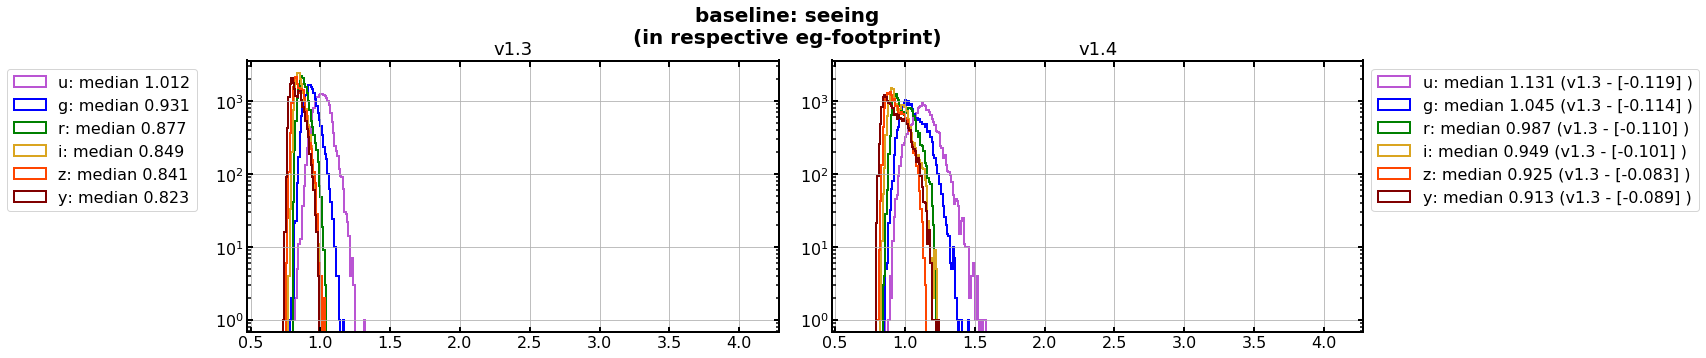

saved compare-hists_baseline_airmass_nside64.png


<Figure size 432x288 with 0 Axes>

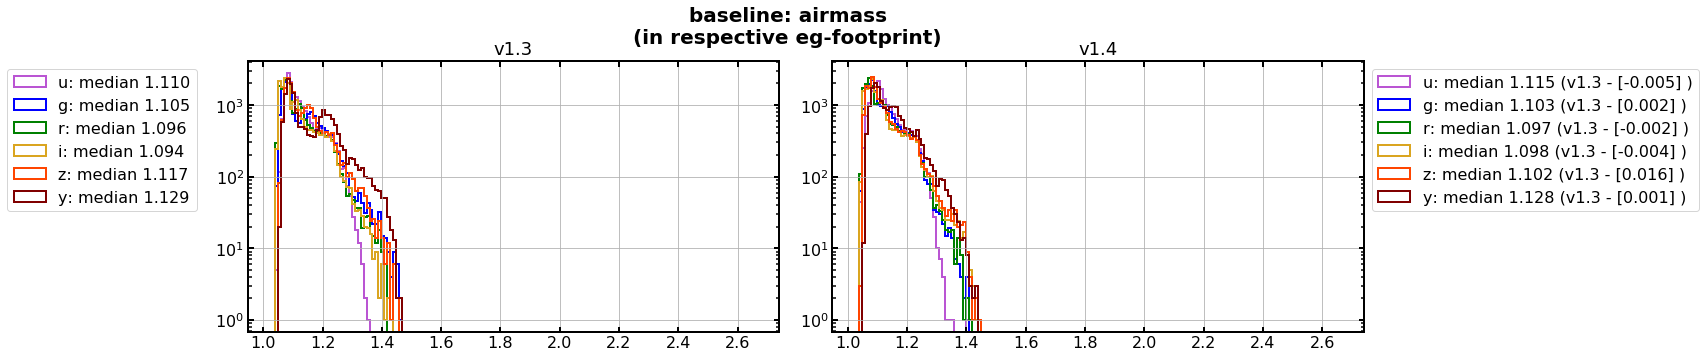

saved compare-hists_baseline_single-visit-5sigma-depth_nside64.png


<Figure size 432x288 with 0 Axes>

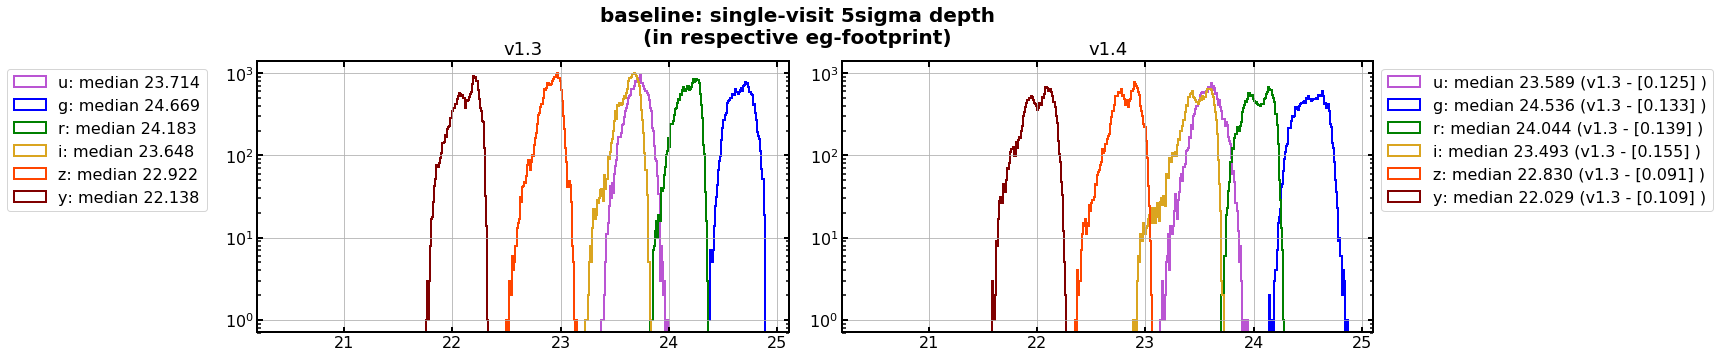

saved compare-hists_baseline_nvisits_nside64.png


<Figure size 432x288 with 0 Axes>

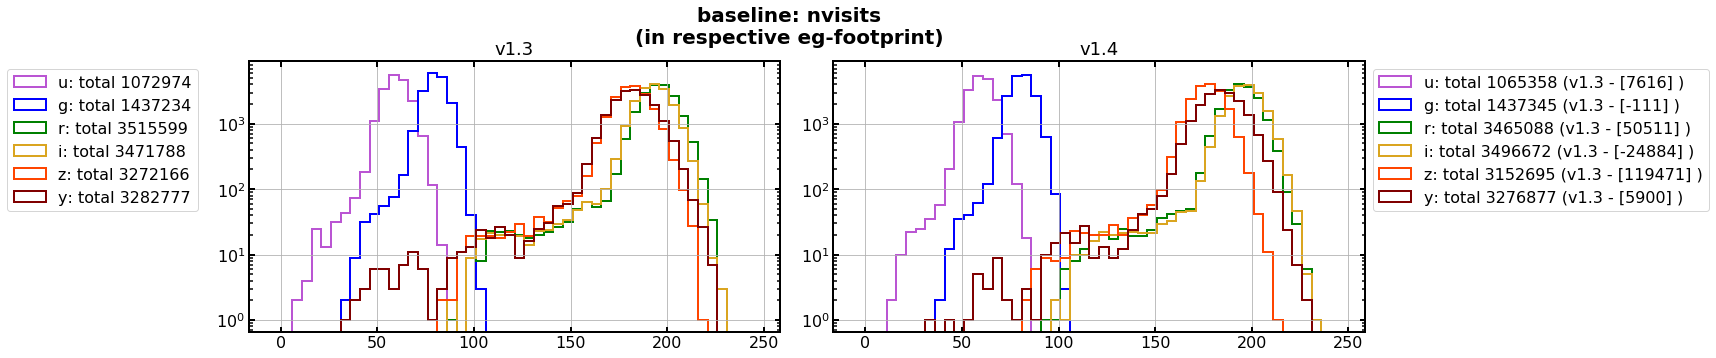

saved compare-hists_baseline_skybrightness_nside64.png


<Figure size 432x288 with 0 Axes>

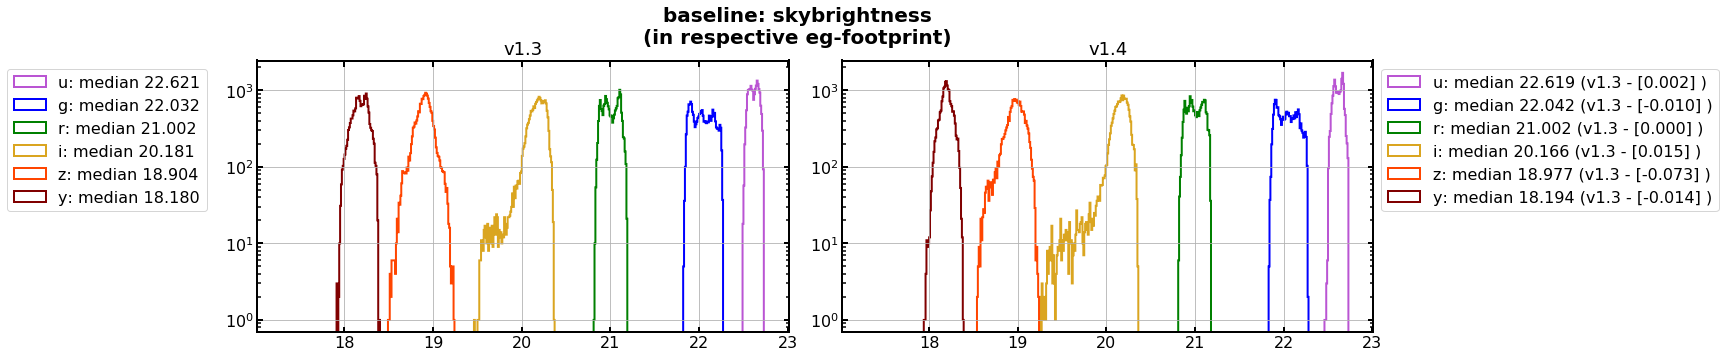

saved compare-hists_baseline_cloud_nside64.png


<Figure size 432x288 with 0 Axes>

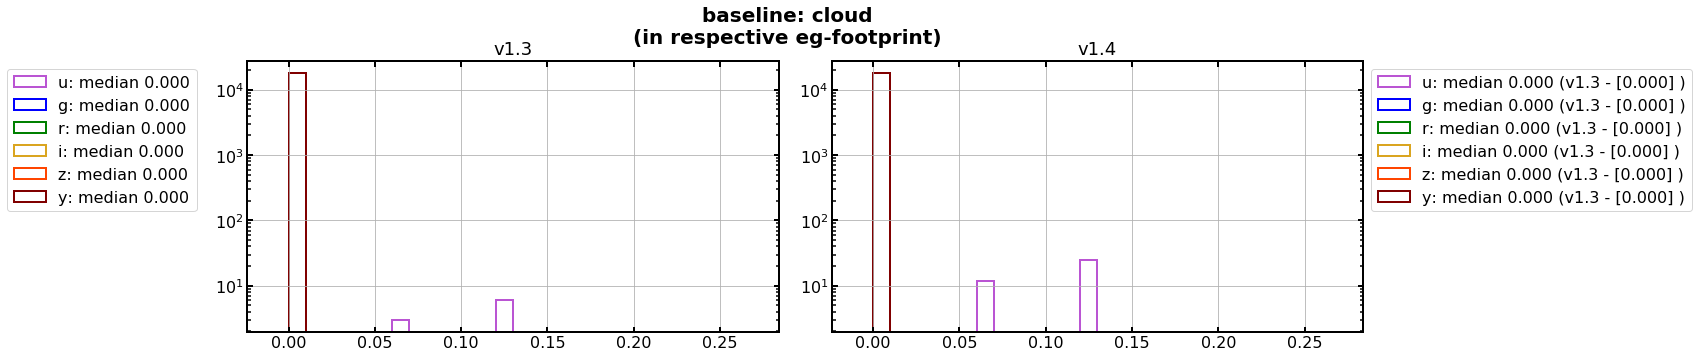

saved compare-hists_baseline_coadd-5sigma-depth_nside64.png


<Figure size 432x288 with 0 Axes>

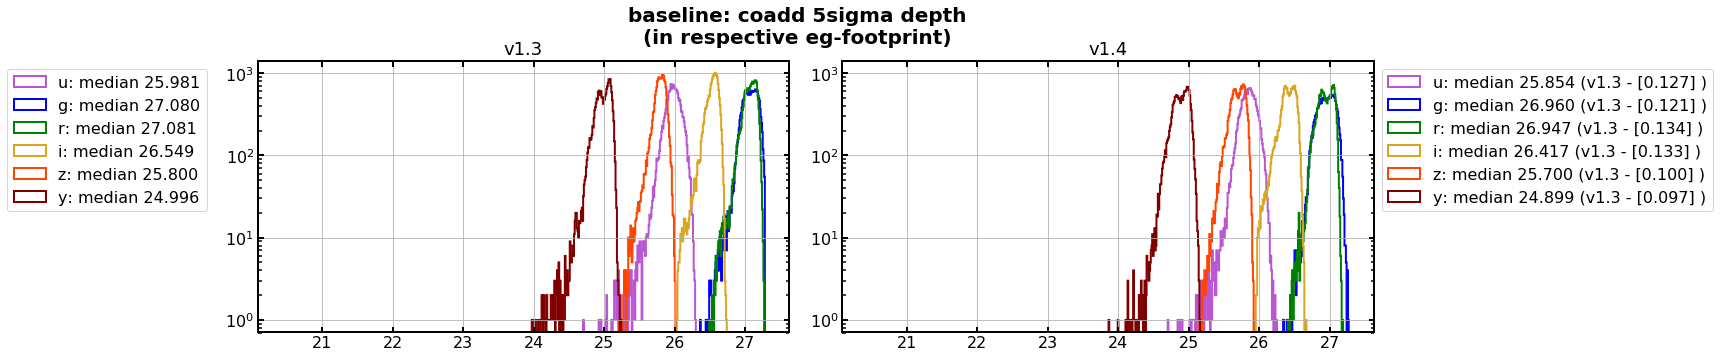

saved compare-hists_baseline_dust-extincted-coadd-depth_nside64.png


<Figure size 432x288 with 0 Axes>

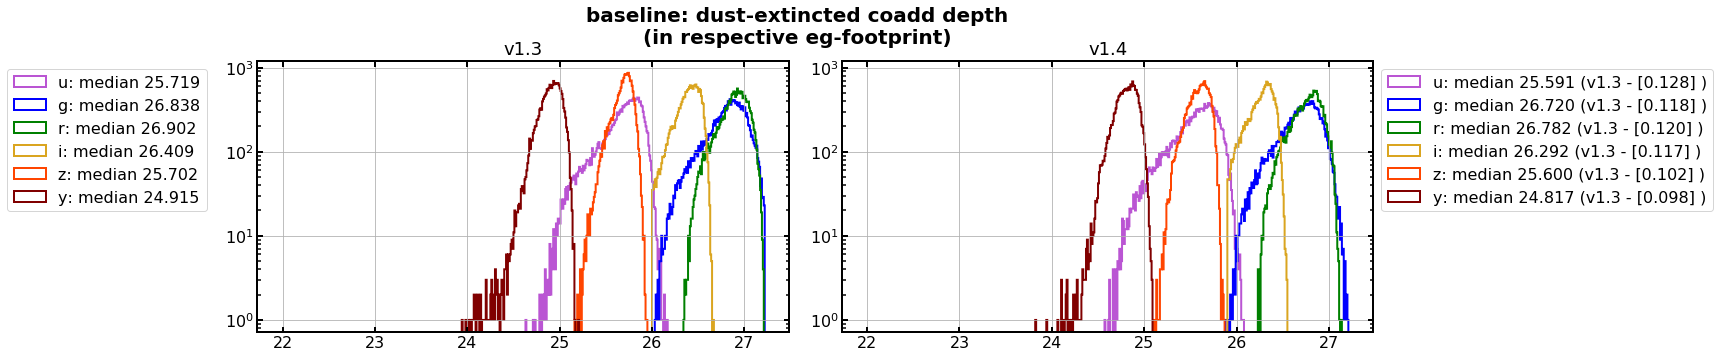

In [11]:
mapper = {'seeing': seeing_bundle, 'airmass': airmass_bundle,
         'single-visit 5sigma depth': five_sigma_bundle, 'nvisits': nvisits_bundle,
          'skybrightness': skybrightness_bundle, 'cloud': cloud_bundle,
          'coadd 5sigma depth': coadd_bundle, 'dust-extincted coadd depth': exgal_bundle
         }

for label in mapper:
    bundle_to_consider = mapper[label]
    ############################################################
    min_all, max_all = 1000, -1000
    version_key = 'v1.3'
    for band in bundle_to_consider[version_key]:
        ind = bundle_to_consider[version_key][band].metricValues.mask == False
        min_all = min(min_all, min(bundle_to_consider[version_key][band].metricValues.data[ind]))
        max_all = max(max_all, max(bundle_to_consider[version_key][band].metricValues.data[ind]))

    min_all, max_all = 1000, -1000
    version_key = 'v1.4'
    for band in bundle_to_consider[version_key]:
        ind = bundle_to_consider[version_key][band].metricValues.mask == False
        min_all = min(min_all, min(bundle_to_consider[version_key][band].metricValues.data[ind]))
        max_all = max(max_all, max(bundle_to_consider[version_key][band].metricValues.data[ind]))
    ############################################################
    if label.__contains__('dust'): min_all = 22
    if label.__contains__('nvisits'):
        bins = np.arange(min_all-5, max_all + 10 , 5)
    else:
        bins = np.arange(min_all-0.01, max_all + 0.02 , 0.01)
    ############################################################

    plt.clf()
    nrows, ncols = 1, 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    plt.subplots_adjust(wspace=0.1, hspace=0.3)

    version_key = 'v1.3'
    meds_1 = {}
    for band in bundle_to_consider[version_key]:
        ind = eg_ind[version_key] #bundle_to_consider[version_key][band].metricValues.mask == False
        
        if label.__contains__('nvisits'):
            meds_1[band] = np.sum(bundle_to_consider[version_key][band].metricValues.data[ind])
            llabel='%s: total %.f' % (band, meds_1[band]),
        else:
            meds_1[band] = np.median(bundle_to_consider[version_key][band].metricValues.data[ind])
            llabel='%s: median %.3f' % (band, meds_1[band])
            
        axes[0].hist(bundle_to_consider[version_key][band].metricValues.data[ind], color=colors[band],
                     histtype='step', label=llabel,
                     lw=2, bins=bins)

    version_key = 'v1.4'
    meds_2 = {}
    for band in bundle_to_consider[version_key]:
        ind = eg_ind[version_key] #bundle_to_consider[version_key][band].metricValues.mask == False
        
        if label.__contains__('nvisits'):
            meds_2[band] = np.sum(bundle_to_consider[version_key][band].metricValues.data[ind])
            llabel='%s: total %.f (v1.3 - [%.f] )' % (band, meds_2[band],  meds_1[band] - meds_2[band]),
        else:
            meds_2[band] = np.median(bundle_to_consider[version_key][band].metricValues.data[ind])
            llabel='%s: median %.3f (v1.3 - [%.3f] )' % (band, meds_2[band], meds_1[band] - meds_2[band])
        
        axes[1].hist(bundle_to_consider[version_key][band].metricValues.data[ind], color=colors[band],
                     histtype='step', label=llabel,
                     lw=2, bins=bins)

    #for band in meds_1:
    #    print('%s: %s difference v1.3-v1.4: %.3f' % (band, label, meds_1[band] - meds_2[band] ))
        
    axes[0].legend(bbox_to_anchor=(-0.08, 1))
    axes[1].legend(bbox_to_anchor=(1,1))
    for i in range(ncols):
        axes[i].set_yscale('log')
        
    ymin, ymax = 1e7, -1e7
    for i in range(ncols):
        ylims = axes[i].get_ylim()
        ymin = min( ymin, ylims[0] )
        ymax = max( ymax, ylims[1] )
        
    for i in range(ncols):
        axes[i].set_ylim(ymin, ymax)
        

    axes[0].set_title('v1.3')
    axes[1].set_title('v1.4')
    
    plt.gcf().set_size_inches(20, 5)
    plt.suptitle('%s: %s\n(in respective eg-footprint)' % (dbname, label), y=1.03, fontsize=20, fontweight='bold')
    filename = 'compare-hists_%s_%s_nside%s.png' % (dbname, label.replace(' ', '-'), nside)
    plt.savefig('%s/%s'%(outdir, filename), format= 'png', bbox_inches='tight')
    print('saved %s' % filename)
    
    plt.show()

#### plot out five sigma depth vs. seeing

#### plot out five sigma depth vs. airmass

### plot out various skymaps